# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars in nearby lanes.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 2 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import cv2
import glob

In [2]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        
        

#### Initialize Lines

In [3]:
left_line=Line()
right_line=Line()
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
small_img_size=(256, 144)

In [4]:
def get_obj_img_points_calibration(cal_img_path):
    cal_images=glob.glob(cal_img_path)
    objpoints=[]
    imgpoints=[]
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    #iterate through calibrated images
    for idx,imag in enumerate(cal_images):
        img=image.imread(imag)
        gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret,corners=cv2.findChessboardCorners(gray,(6,9),None)
        if ret==True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints,imgpoints

In [5]:
def get_camera_calibrated_image(image,objpoints,imgpoints):
    # Do camera calibration given object points and image points
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

In [31]:
def apply_gradient_color(image,color_thresh=(0,255),gradient_thresh=(0,255)):
    #convert to hls
    R=image[:,:,2]
    hls=cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    #get S channel
    #l_channel = hls[:,:,1]
    S=hls[:,:,2]
    #create binary image and apply threshold
    binary_img=np.zeros_like(S)
    binary_img[(S>=color_thresh[0])&(S<color_thresh[1])]=1
    #apply sobel to l-channel
    sobelx=cv2.Sobel(R,cv2.CV_64F,1,0)
    abs_sobel=np.absolute(sobelx)
    scaled_sobel=np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_sobel_grad=np.zeros_like(scaled_sobel)
    binary_sobel_grad[(scaled_sobel>=gradient_thresh[0])&(scaled_sobel<gradient_thresh[1]) | (S>=color_thresh[0])&(S<color_thresh[1])]=1
    #stack each channel
    #color_img=np.dstack((np.zeros_like(binary_sobel_grad),binary_sobel_grad,binary_img))*255
    return binary_sobel_grad

In [7]:
def perspective_transform(image):
    #source coordinates
    img_size=(image.shape[1],image.shape[0])
    
    src=np.float32(
        [[690, 450],
         [1110, 720],
         [175, 720],
         [595, 450]
        ])
    #desired coordinates
    dsrd=np.float32(
        [[980, 0],
         [980, 720],
         [300, 720],
         [300, 0]
        ])
    M=cv2.getPerspectiveTransform(src,dsrd)
    Minv=cv2.getPerspectiveTransform(dsrd,src)
    warped=cv2.warpPerspective(image,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped,Minv

In [8]:
def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox>(left_fit[0]*(nonzeroy**2)+left_fit[1]*(nonzeroy)+left_fit[2]-margin)) & 
                       (nonzerox< (left_fit[0]*(nonzeroy**2)+left_fit[1]*(nonzeroy)+left_fit[2]+margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2)+right_fit[1]*(nonzeroy)+right_fit[2]-margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2)+right_fit[1]*(nonzeroy)+right_fit[2]+margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    y_max=binary_image.shape[0]
    #Add values to Line()
    left_Line.detected=True
    left_Line.current_fit=left_fitx
    right_Line.detected=True
    right_Line.current_fit=right_fitx
    left_Line.radius_of_curvature=calculate_curvature(y_max,left_fit_m)
    right_Line.radius_of_curvature=calculate_curvature(y_max,right_fit_m)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

In [9]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]**ploty + left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]**ploty + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [10]:
def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    max_y=binary_warped.shape[0]
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)&(nonzeroy>=win_y_low)&(nonzeroy<win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox>=win_xright_low)&(nonzerox<win_xright_high)&(nonzeroy>=win_y_low)&(nonzeroy<win_y_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit new polynomials
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #Add values to Line()
    left_Line.detected=True
    left_Line.current_fit=left_fit
    right_Line.detected=True
    right_Line.current_fit=right_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    #getting x&y values in real world space
    
    #left_fitx_m=left_fit[0]*(ploty*ym_per_pix)**2+left_fit[1]*ploty*ym_per_pix+left_fit[2]
    #right_fit_m=right_fit[0]*(ploty*ym_per_pix)**2+right_fit[1]*ploty*ym_per_pix+right_fit[2]
    y_max=binary_image.shape[0]
    left_Line.radius_of_curvature=calculate_curvature(y_max,left_fit_m)
    right_Line.radius_of_curvature=calculate_curvature(y_max,right_fit_m)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

In [11]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
def fit_polynomial(binary_warped,previous_left_fit=None,previous_right_fit=None):
    result=find_lane_pixels(binary_warped)
    return result
    # Find our lane pixels first
    if previous_left_fit is None:
        print('no previous line')
        return find_lane_pixels(binary_warped)
    else:
        print('previous line')
        return search_around_poly(binary_warped)
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    #out_img=np.zeros_like(binary_warped)
    

In [12]:
def warp_lane_on_image(img,Minv):
    y_max=img.shape[0]
    ploty=np.linspace(0,y_max-1,y_max)
    color_warp=np.zeros_like(img).astype(np.uint8)
    print(left_Line.current_fit)
    left_fit=left_Line.current_fit
    right_fit=right_Line.current_fit
    #calculate points
    left_fitx=left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx=right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    print(left_Line.radius_of_curvature)
    # Draw info of curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    #color_warp = np.zeros_like(img).astype(np.uint8)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    output = cv2.addWeighted(img,1,newwarp,0.3,0)
        
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {} m'.format(round(left_Line.radius_of_curvature,2)), (50, 50), font, 2, fontColor, 2)
    cv2.putText(output, 'Right curvature: {} m'.format(round(right_Line.radius_of_curvature,2)), (50, 120), font, 2, fontColor, 2)
    
    
    #cv2.putText(output, 'Left curvature: {:.0f} m'.format(left_Line.radius_of_curvature),(10,50),font, 1,(255,255,255),2)
    #cv2.putText(output, 'Right curvature: {:.0f} m'.format(right_Line.radius_of_curvature),(10,100), font, 1,(255,255,255),2)
    return output

In [13]:
def calculate_curvature(y_max,fit):
    return((1+((2*fit[0]*y_max*ym_per_pix+fit[1])**2))**1.5)/np.absolute(2*fit[0])

In [14]:
def draw_original_modified_images(original,modified):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(original)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(modified, cmap='gray')
    ax2.set_title('Thresholded S', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

##### main function starts here

In [24]:
#Initialize left and right lines
left_Line=Line()
right_Line=Line()
calibration_image_path="camera_cal/calibration*.jpg"
objpoints,imgpoints=get_obj_img_points_calibration(calibration_image_path)
# Test undistortion on an image
img = cv2.imread('test_images/test4.jpg')
print('initial_shape',img.shape)

calibrated_image=get_camera_calibrated_image(img,objpoints,imgpoints)
cv2.imwrite('output_images/calibrated_image.jpg',calibrated_image)
print('shape after calibration',calibrated_image.shape)

initial_shape (720, 1280, 3)
shape after calibration (720, 1280, 3)


shape after color gradient (720, 1280)


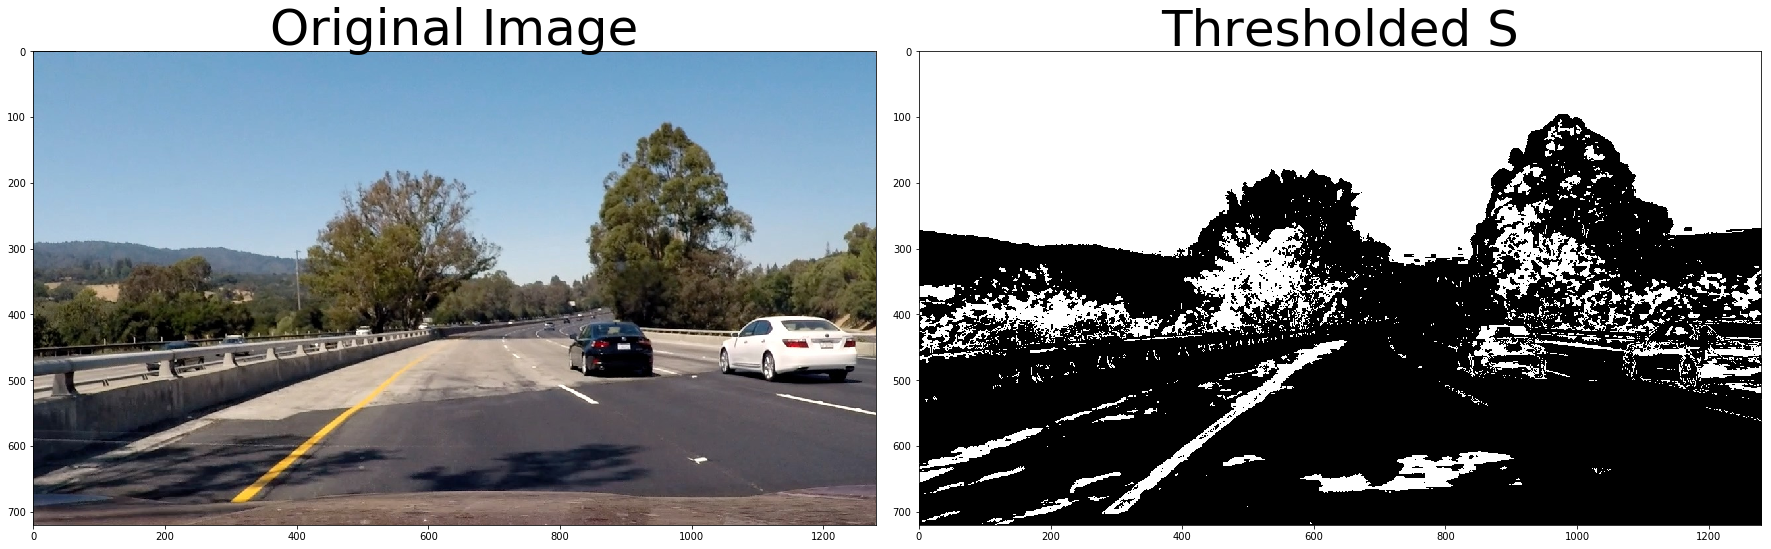

In [32]:
#do color treshold and gradient
binary_image=apply_gradient_color(calibrated_image,color_thresh=(80,255),gradient_thresh=(80,150))
print('shape after color gradient',binary_image.shape)
cv2.imwrite('output_images/color_gradient_image.jpg',binary_image)
draw_original_modified_images(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),binary_image)

shape after perspective transform (720, 1280)


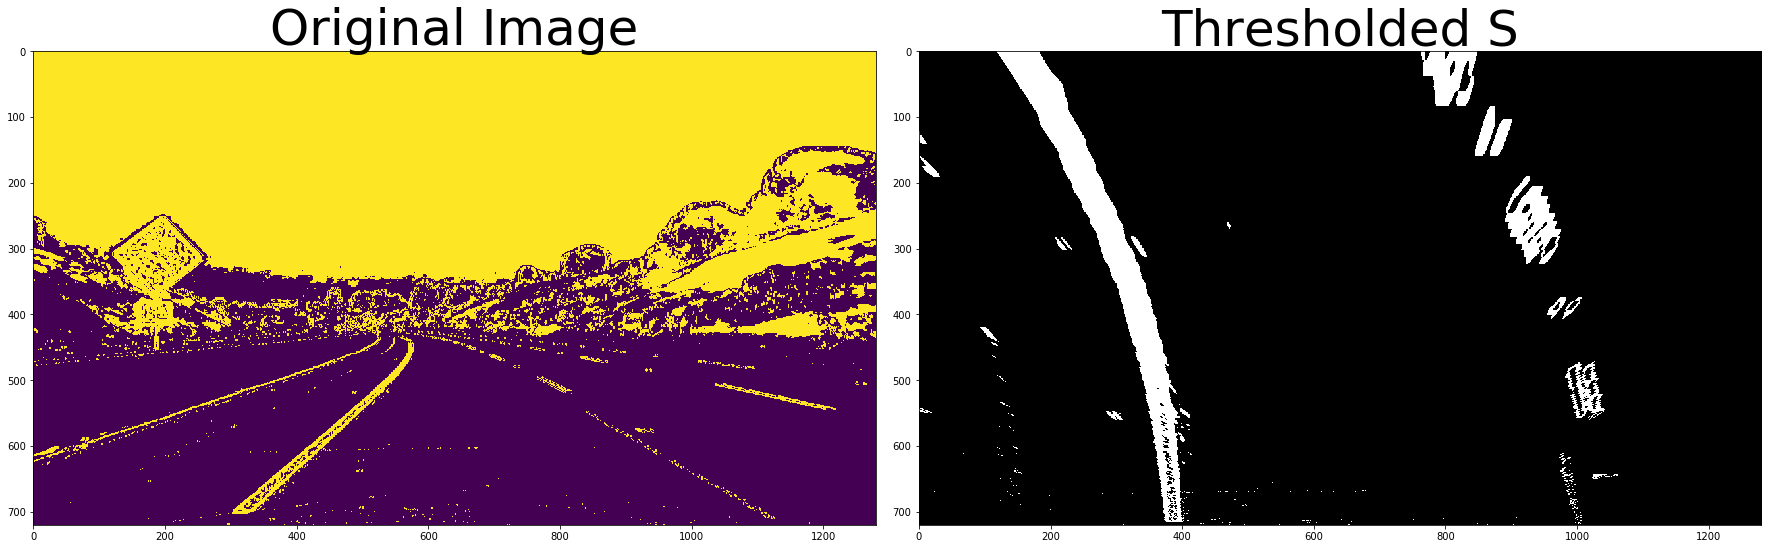

In [17]:
#do a perspective transform of image
transformed_image,Minv=perspective_transform(binary_image)
#gray=cv2.cvtColor(transformed_image,cv2.COLOR_RGB2GRAY)
cv2.imwrite('output_images/perspective_image.jpg',transformed_image)
print('shape after perspective transform',transformed_image.shape)
draw_original_modified_images(binary_image,transformed_image)

True

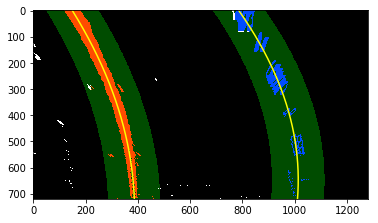

In [18]:
#draw_original_modified_images(img,gray)
imag=fit_polynomial(transformed_image,previous_left_fit=None,previous_right_fit=None)
plt.imshow(imag)
cv2.imwrite('output_images/polynomial_image.jpg',imag)

[-4.04748091e-04  6.20286525e-01  1.49774560e+02]
405.7642029587874


True

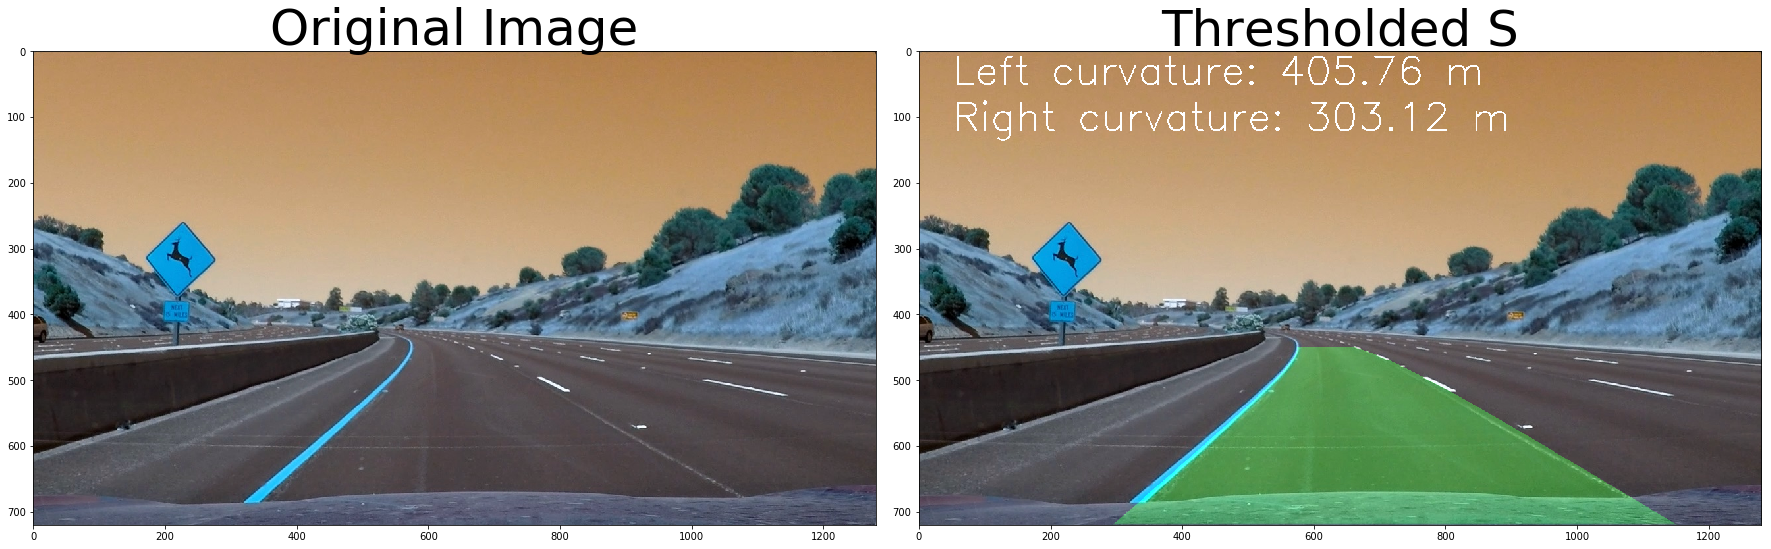

In [19]:
warp_img=warp_lane_on_image(img,Minv)
#lane_on_img=cv2.addWeighted(img,1,warp_img,0.3,0)
draw_original_modified_images(img,warp_img)
cv2.imwrite('output_images/final_image.jpg',warp_img)

Applying on Video

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def pipeline(video_frame):
    #calibration_image_path="camera_cal/calibration*.jpg"
    #objpoints,imgpoints=get_obj_img_points_calibration(calibration_image_path)
    calibrated_image_video=get_camera_calibrated_image(video_frame,objpoints,imgpoints)
    #do color treshold and gradient
    binary_image_video=apply_gradient_color(calibrated_image_video,color_thresh=(80,255),gradient_thresh=(20,100))
    #do a perspective transform of image
    transformed_image_video,Minv=perspective_transform(binary_image_video)
    image_video=fit_polynomial(transformed_image_video)
    warp_img=warp_lane_on_image(video_frame,Minv)
    return warp_img

[ 1.26150402e-03 -1.45130262e+00  7.52647755e+02]
130.6027662240945
Moviepy - Building video challege_output.mp4.mp4.
Moviepy - Writing video challege_output.mp4.mp4



t:   0%|                                     | 0/150 [00:00<?, ?it/s, now=None]

[ 1.26150402e-03 -1.45130262e+00  7.52647755e+02]
130.6027662240945


t:   1%|▍                            | 2/150 [00:01<02:06,  1.17it/s, now=None]

[-3.01872728e-05 -4.62016003e-02  2.14253329e+02]
5441.319768738617


t:   2%|▌                            | 3/150 [00:03<03:04,  1.25s/it, now=None]

[ 5.07718608e-04 -5.72549465e-01  6.22919116e+02]
323.65646662876793


t:   3%|▊                            | 4/150 [00:05<03:24,  1.40s/it, now=None]

[-2.71586695e-05 -1.17790596e-01  6.76220473e+02]
6050.529335892168


t:   3%|▉                            | 5/150 [00:07<03:34,  1.48s/it, now=None]

[-5.90126470e-05 -1.21107139e-01  6.80887561e+02]
2785.7608785247376


t:   4%|█▏                           | 6/150 [00:08<03:36,  1.50s/it, now=None]

[-1.11696106e-04  1.01319647e-02  2.10326442e+02]
1471.105700827404


t:   5%|█▎                           | 7/150 [00:10<03:40,  1.54s/it, now=None]

[-6.92545739e-05  1.25136433e-02  1.91076155e+02]
2371.783856384109


t:   5%|█▌                           | 8/150 [00:12<03:43,  1.57s/it, now=None]

[-4.25715961e-05  6.58264535e-03  1.83931434e+02]
3857.9384455325644


t:   6%|█▋                           | 9/150 [00:13<03:48,  1.62s/it, now=None]

[ 4.95383838e-04 -5.46800433e-01  6.44346634e+02]
331.7361091189655


t:   7%|█▊                          | 10/150 [00:15<03:44,  1.60s/it, now=None]

[ 1.17949801e-03 -1.34814919e+00  7.28407158e+02]
139.64712196390036


t:   7%|██                          | 11/150 [00:17<03:43,  1.61s/it, now=None]

[ 5.82591701e-04 -6.46693752e-01  6.38188987e+02]
282.14142197819575


t:   8%|██▏                         | 12/150 [00:18<03:39,  1.59s/it, now=None]

[ 1.16395086e-03 -1.33999891e+00  7.47658973e+02]
141.47910290082797


t:   9%|██▍                         | 13/150 [00:20<03:35,  1.58s/it, now=None]

[ 1.08507688e-03 -1.24364482e+00  7.21588944e+02]
151.72193285647907


t:   9%|██▌                         | 14/150 [00:21<03:35,  1.58s/it, now=None]

[ 1.18496588e-03 -1.36184104e+00  7.43881068e+02]
138.989201149466


t:  10%|██▊                         | 15/150 [00:23<03:33,  1.58s/it, now=None]

[ 2.38496289e-04 -2.63360696e-01  6.60949956e+02]
688.6989575630234


t:  11%|██▉                         | 16/150 [00:24<03:32,  1.58s/it, now=None]

[ 1.16532027e-03 -1.33792960e+00  7.27664103e+02]
141.3221503582417


t:  11%|███▏                        | 17/150 [00:26<03:32,  1.60s/it, now=None]

[ 1.28103577e-03 -1.48604475e+00  7.17703584e+02]
128.59664877886811


t:  12%|███▎                        | 18/150 [00:28<03:29,  1.59s/it, now=None]

[ 1.38607914e-03 -1.60571020e+00  7.26981447e+02]
118.91876428387187


t:  13%|███▌                        | 19/150 [00:29<03:27,  1.59s/it, now=None]

[-6.52974684e-05 -6.89915304e-02  2.39402090e+02]
2516.6686361651064


t:  13%|███▋                        | 20/150 [00:31<03:36,  1.66s/it, now=None]

[ 1.22733368e-03 -1.38047385e+00  6.38187546e+02]
134.2914858512137


t:  14%|███▉                        | 21/150 [00:33<03:30,  1.63s/it, now=None]

[ 1.17968327e-03 -1.33992746e+00  7.12543867e+02]
139.6454409574898


t:  15%|████                        | 22/150 [00:34<03:23,  1.59s/it, now=None]

[ 4.05571013e-04 -4.57448745e-01  6.98638841e+02]
405.0837874353314


t:  15%|████▎                       | 23/150 [00:36<03:20,  1.58s/it, now=None]

[ 1.32340861e-03 -1.52864924e+00  7.75779154e+02]
124.51986785920319


t:  16%|████▍                       | 24/150 [00:37<03:22,  1.61s/it, now=None]

[ 3.16904665e-04 -3.85218472e-01  7.52594701e+02]
518.284517236565


t:  17%|████▋                       | 25/150 [00:39<03:30,  1.69s/it, now=None]

[ 3.50545495e-04 -4.09283110e-01  7.49236789e+02]
468.5922019416653


t:  17%|████▊                       | 26/150 [00:41<03:32,  1.71s/it, now=None]

[-6.06421950e-05 -6.76714582e-03  2.05257112e+02]
2708.705133851175


t:  18%|█████                       | 27/150 [00:43<03:33,  1.74s/it, now=None]

[ 4.60193416e-04 -5.46503098e-01  7.89745138e+02]
356.9808449062876


t:  19%|█████▏                      | 28/150 [00:45<03:32,  1.74s/it, now=None]

[-3.94654509e-05 -1.24191043e-01  2.66721373e+02]
4164.570397586289


t:  19%|█████▍                      | 29/150 [00:47<03:40,  1.82s/it, now=None]

[-3.37431773e-05 -1.57338386e-01  6.95034196e+02]
4871.943908310693


t:  20%|█████▌                      | 30/150 [00:48<03:42,  1.86s/it, now=None]

[-9.97000919e-05 -6.15204663e-02  2.52234532e+02]
1648.880106145611


t:  21%|█████▊                      | 31/150 [00:50<03:38,  1.84s/it, now=None]

[-4.37618674e-05 -1.48821587e-01  6.84424406e+02]
3756.801720042856


t:  21%|█████▉                      | 32/150 [00:52<03:33,  1.81s/it, now=None]

[-1.50998553e-04 -3.56534001e-02  6.56627979e+02]
1089.286767639699


t:  22%|██████▏                     | 33/150 [00:54<03:31,  1.81s/it, now=None]

[-2.22030721e-04  5.89218588e-02  2.27523619e+02]
740.8724432023497


t:  23%|██████▎                     | 34/150 [00:56<03:43,  1.92s/it, now=None]

[ 8.05978080e-05 -2.14722986e-01  6.73052615e+02]
2038.0866622527915


t:  23%|██████▌                     | 35/150 [00:58<03:54,  2.04s/it, now=None]

[ 3.95189851e-04 -4.93645691e-01  7.30553629e+02]
415.6212033639433


t:  24%|██████▋                     | 36/150 [01:00<03:38,  1.92s/it, now=None]

[ 7.95976810e-04 -8.87149822e-01  8.16750083e+02]
206.65532123600406


t:  25%|██████▉                     | 37/150 [01:01<03:24,  1.81s/it, now=None]

[-2.29059844e-04  3.12199997e-02  2.52376493e+02]
718.5038457053447


t:  25%|███████                     | 38/150 [01:03<03:16,  1.75s/it, now=None]

[-2.16536387e-04  2.42558837e-02  2.67616355e+02]
759.9398861594069


t:  26%|███████▎                    | 39/150 [01:05<03:15,  1.76s/it, now=None]

[-2.30637296e-04  5.42617007e-02  2.50661510e+02]
713.3836675384565


t:  27%|███████▍                    | 40/150 [01:07<03:09,  1.72s/it, now=None]

[ 7.80046645e-04 -8.16525998e-01  7.74694929e+02]
211.01285297289652


t:  27%|███████▋                    | 41/150 [01:08<03:01,  1.66s/it, now=None]

[ 6.44997146e-04 -6.48067097e-01  7.58192111e+02]
255.1007346456494


t:  28%|███████▊                    | 42/150 [01:10<02:56,  1.63s/it, now=None]

[ 1.20634357e-03 -1.36574589e+00  8.50044241e+02]
136.58946530330132


t:  29%|████████                    | 43/150 [01:11<02:58,  1.66s/it, now=None]

[ 7.71228379e-04 -7.99721757e-01  7.63791021e+02]
213.43862953147476


t:  29%|████████▏                   | 44/150 [01:13<02:54,  1.65s/it, now=None]

[ 1.24596107e-03 -1.40459833e+00  8.66889122e+02]
132.29047410786796


t:  30%|████████▍                   | 45/150 [01:14<02:49,  1.61s/it, now=None]

[ 7.84746574e-04 -8.50828970e-01  7.95410397e+02]
209.66751437735385


t:  31%|████████▌                   | 46/150 [01:16<02:46,  1.60s/it, now=None]

[ 8.05977773e-04 -8.68541679e-01  7.96144608e+02]
204.18057751032845


t:  31%|████████▊                   | 47/150 [01:18<02:43,  1.58s/it, now=None]

[ 6.93418957e-04 -7.42897249e-01  7.73255115e+02]
237.2098977709617


t:  32%|████████▉                   | 48/150 [01:19<02:39,  1.57s/it, now=None]

[ 7.19613848e-04 -7.58176839e-01  8.04353742e+02]
228.64116126675412


t:  33%|█████████▏                  | 49/150 [01:21<02:41,  1.60s/it, now=None]

[ 7.59201859e-04 -8.07247309e-01  8.10469655e+02]
216.74222974253075


t:  33%|█████████▎                  | 50/150 [01:22<02:37,  1.58s/it, now=None]

[-2.77098484e-04  8.33502839e-02  2.87008867e+02]
594.091739459824


t:  34%|█████████▌                  | 51/150 [01:24<02:37,  1.60s/it, now=None]

[ 1.04124082e-03 -1.16251200e+00  8.57417132e+02]
158.15439980507352


t:  35%|█████████▋                  | 52/150 [01:26<02:46,  1.70s/it, now=None]

[-3.30119163e-04  1.40011784e-01  2.64210476e+02]
498.82828643911745


t:  35%|█████████▉                  | 53/150 [01:28<02:54,  1.80s/it, now=None]

[-3.42701605e-04  1.62098227e-01  2.51868575e+02]
480.48295506031667


t:  36%|██████████                  | 54/150 [01:30<02:47,  1.75s/it, now=None]

[-1.55975856e-04  9.95039679e-02  1.88223602e+02]
1053.2961756454492


t:  37%|██████████▎                 | 55/150 [01:32<02:52,  1.81s/it, now=None]

[-8.07374631e-05  5.84479854e-02  1.80289331e+02]
2034.2474373441114


t:  37%|██████████▍                 | 56/150 [01:33<02:47,  1.78s/it, now=None]

[-5.64955177e-05  4.42647800e-02  1.77766143e+02]
2906.9948648535865


t:  38%|██████████▋                 | 57/150 [01:35<02:43,  1.76s/it, now=None]

[-6.31636216e-05  4.81140391e-02  1.80394756e+02]
2600.135942023804


t:  39%|██████████▊                 | 58/150 [01:37<02:43,  1.77s/it, now=None]

[-1.64825771e-04 -2.07829495e-02  2.87894135e+02]
997.9686154733225


t:  39%|███████████                 | 59/150 [01:38<02:37,  1.73s/it, now=None]

[-2.44641319e-04  4.67457321e-02  3.11374700e+02]
672.8092592278997


t:  40%|███████████▏                | 60/150 [01:40<02:34,  1.71s/it, now=None]

[-2.23093421e-04  1.87034632e-02  3.45581447e+02]
737.7615115914582


t:  41%|███████████▍                | 61/150 [01:42<02:30,  1.69s/it, now=None]

[-2.58753185e-04  5.63860320e-02  3.32164546e+02]
636.2174513759297


t:  41%|███████████▌                | 62/150 [01:43<02:28,  1.69s/it, now=None]

[ 5.15492116e-04 -5.82612104e-01  7.95013663e+02]
318.77856715275425


t:  42%|███████████▊                | 63/150 [01:45<02:19,  1.61s/it, now=None]

[ 4.88760103e-04 -5.65346957e-01  8.00394597e+02]
336.162342088866


t:  43%|███████████▉                | 64/150 [01:46<02:17,  1.60s/it, now=None]

[4.89362874e-06 8.57799117e-03 3.67759402e+02]
33559.49199989733


t:  43%|████████████▏               | 65/150 [01:48<02:26,  1.72s/it, now=None]

[1.11841917e-05 2.68295862e-03 3.66812443e+02]
14683.95125972079


t:  44%|████████████▎               | 66/150 [01:50<02:26,  1.75s/it, now=None]

[-4.27143350e-05 -1.27596996e-02  3.54691161e+02]
3845.280358423192


t:  45%|████████████▌               | 67/150 [01:52<02:26,  1.77s/it, now=None]

[-2.75218355e-04  8.02116776e-02  3.51661091e+02]
598.1541492207142


t:  45%|████████████▋               | 68/150 [01:54<02:21,  1.72s/it, now=None]

[ 4.77268078e-04 -6.12334149e-01  8.32543889e+02]
344.14408453285927


t:  46%|████████████▉               | 69/150 [01:55<02:13,  1.65s/it, now=None]

[ 6.44938582e-04 -7.56768579e-01  8.50683376e+02]
254.82107421012006


t:  47%|█████████████               | 70/150 [01:57<02:10,  1.63s/it, now=None]

[ 8.14457179e-04 -9.35768161e-01  8.97249700e+02]
201.91306005190015


t:  47%|█████████████▎              | 71/150 [01:58<02:05,  1.59s/it, now=None]

[ 1.22930070e-03 -1.46474919e+00  9.85393540e+02]
133.89459274937118


t:  48%|█████████████▍              | 72/150 [02:00<02:06,  1.63s/it, now=None]

[ 8.47064217e-04 -9.44988947e-01  8.89458992e+02]
194.23101770308318


t:  49%|█████████████▋              | 73/150 [02:02<02:08,  1.66s/it, now=None]

[ 8.45673785e-04 -9.38500495e-01  8.92067397e+02]
194.56202575949942


t:  49%|█████████████▊              | 74/150 [02:03<02:08,  1.70s/it, now=None]

[ 1.54995962e-03 -1.78307277e+00  1.04042105e+03]
106.47123315570973


t:  50%|██████████████              | 75/150 [02:05<02:08,  1.71s/it, now=None]

[ 1.60366093e-03 -1.85598571e+00  1.02839253e+03]
102.91572967410133


t:  51%|██████████████▏             | 76/150 [02:07<02:07,  1.72s/it, now=None]

[ 1.38686828e-03 -1.58236147e+00  1.00718926e+03]
118.9075110367483


t:  51%|██████████████▎             | 77/150 [02:09<02:09,  1.78s/it, now=None]

[ 1.29997854e-03 -1.49511148e+00  9.30760092e+02]
126.76367941953102


t:  52%|██████████████▌             | 78/150 [02:11<02:06,  1.76s/it, now=None]

[ 4.12542283e-04 -6.06646921e-01  6.53832058e+02]
398.08611477286246


t:  53%|██████████████▋             | 79/150 [02:12<02:08,  1.81s/it, now=None]

[ 8.98053498e-04 -1.11401749e+00  8.03149548e+02]
183.01138861834983


t:  53%|██████████████▉             | 80/150 [02:14<02:05,  1.79s/it, now=None]

[ 1.05562645e-03 -1.26221337e+00  8.28176324e+02]
155.82259128045803


t:  54%|███████████████             | 81/150 [02:16<02:02,  1.78s/it, now=None]

[ 1.43457208e-03 -1.64684390e+00  9.93604267e+02]
114.96319646185394


t:  55%|███████████████▎            | 82/150 [02:18<01:59,  1.76s/it, now=None]

[ 7.03793550e-04 -7.83784857e-01  8.46755891e+02]
233.64223050726065


t:  55%|███████████████▍            | 83/150 [02:19<01:55,  1.72s/it, now=None]

[ 1.18181103e-03 -1.36488188e+00  9.36178936e+02]
139.34288179119682


t:  56%|███████████████▋            | 84/150 [02:21<01:53,  1.72s/it, now=None]

[ 1.14087967e-03 -1.32273123e+00  8.44908959e+02]
144.30372094180953


t:  57%|███████████████▊            | 85/150 [02:23<01:50,  1.69s/it, now=None]

[ 1.34812456e-03 -1.56217239e+00  9.28063771e+02]
122.24157699486925


t:  57%|████████████████            | 86/150 [02:24<01:46,  1.66s/it, now=None]

[ 1.17788857e-03 -1.36152951e+00  9.30921575e+02]
139.80171020246533


t:  58%|████████████████▏           | 87/150 [02:26<01:42,  1.62s/it, now=None]

[ 1.41362666e-03 -1.65005310e+00  9.41835629e+02]
116.59119665359441


t:  59%|████████████████▍           | 88/150 [02:27<01:39,  1.61s/it, now=None]

[ 7.86156043e-04 -8.95721559e-01  8.63011854e+02]
209.18011811757165


t:  59%|████████████████▌           | 89/150 [02:29<01:37,  1.60s/it, now=None]

[-3.13477282e-04  1.25814408e-01  3.93259204e+02]
525.2283733863796


t:  60%|████████████████▊           | 90/150 [02:31<01:36,  1.61s/it, now=None]

[ 1.31174462e-03 -1.51954221e+00  8.94469545e+02]
125.6097300802365


t:  61%|████████████████▉           | 91/150 [02:32<01:36,  1.63s/it, now=None]

[-2.49486661e-04  1.51960786e-01  3.02872132e+02]
658.941500834249


t:  61%|█████████████████▏          | 92/150 [02:34<01:36,  1.66s/it, now=None]

[-2.17379390e-04  1.35697716e-01  2.94381215e+02]
756.0578823667709


t:  62%|█████████████████▎          | 93/150 [02:36<01:37,  1.70s/it, now=None]

[-2.65051199e-04  1.59189081e-01  2.99287738e+02]
620.3442824492291


t:  63%|█████████████████▌          | 94/150 [02:38<01:37,  1.75s/it, now=None]

[ 6.65029883e-04 -8.93701186e-01  6.96808070e+02]
246.97075929942017


t:  63%|█████████████████▋          | 95/150 [02:39<01:34,  1.71s/it, now=None]

[ 9.04131846e-04 -1.13213464e+00  7.62381800e+02]
181.76669652603564


t:  64%|█████████████████▉          | 96/150 [02:41<01:31,  1.69s/it, now=None]

[ 3.07675851e-04 -4.03311790e-01  6.88277592e+02]
533.785759502779


t:  65%|██████████████████          | 97/150 [02:42<01:25,  1.61s/it, now=None]

[-3.04715457e-04  1.11620360e-01  4.32252122e+02]
540.3442568437722


t:  65%|██████████████████▎         | 98/150 [02:44<01:23,  1.61s/it, now=None]

[-3.12104965e-04  1.19843827e-01  4.22224836e+02]
527.5710579631979


t:  66%|██████████████████▍         | 99/150 [02:46<01:22,  1.62s/it, now=None]

[-3.25982188e-04  1.37157229e-01  4.05644585e+02]
505.1336041435852


t:  67%|██████████████████         | 100/150 [02:47<01:21,  1.64s/it, now=None]

[ 1.09693630e-03 -1.27474199e+00  9.71050382e+02]
150.04998055258687


t:  67%|██████████████████▏        | 101/150 [02:49<01:21,  1.67s/it, now=None]

[ 1.01619074e-03 -1.21894803e+00  9.37538241e+02]
161.84315142966688


t:  68%|██████████████████▎        | 102/150 [02:51<01:18,  1.64s/it, now=None]

[ 9.61445739e-04 -1.15928679e+00  9.12090323e+02]
171.02141197729551


t:  69%|██████████████████▌        | 103/150 [02:52<01:16,  1.62s/it, now=None]

[ 9.84711787e-04 -1.19375984e+00  9.18045933e+02]
166.97888786518234


t:  69%|██████████████████▋        | 104/150 [02:54<01:13,  1.60s/it, now=None]

[ 9.54349603e-04 -1.16141591e+00  8.90222242e+02]
172.27057795906572


t:  70%|██████████████████▉        | 105/150 [02:55<01:12,  1.60s/it, now=None]

[ 7.93012715e-04 -9.14973133e-01  8.42072393e+02]
207.34974230814524


t:  71%|███████████████████        | 106/150 [02:57<01:08,  1.56s/it, now=None]

[ 1.20472194e-03 -1.40046215e+00  9.37725482e+02]
136.68719309411253


t:  71%|███████████████████▎       | 107/150 [02:58<01:07,  1.56s/it, now=None]

[ 6.62591517e-04 -8.08389765e-01  7.95073367e+02]
247.98225478944977


t:  72%|███████████████████▍       | 108/150 [03:00<01:06,  1.57s/it, now=None]

[ 5.12204233e-04 -6.00468877e-01  7.97595343e+02]
320.77292951873363


t:  73%|███████████████████▌       | 109/150 [03:01<01:03,  1.55s/it, now=None]

[ 1.10127223e-04 -2.00353248e-01  5.74805939e+02]
1491.3083113564635


t:  73%|███████████████████▊       | 110/150 [03:03<01:02,  1.56s/it, now=None]

[-2.31988572e-04  2.36436348e-01  4.72996652e+02]
708.0715694070445


t:  74%|███████████████████▉       | 111/150 [03:05<01:01,  1.59s/it, now=None]

[ 5.98243620e-04 -7.56365428e-01  8.00131534e+02]
274.5880061878755


t:  75%|████████████████████▏      | 112/150 [03:06<00:59,  1.57s/it, now=None]

[-2.67617615e-04  9.43019237e-02  5.12226540e+02]
614.9172829627025


t:  75%|████████████████████▎      | 113/150 [03:08<01:00,  1.64s/it, now=None]

[-3.12558874e-04  9.46902844e-02  4.82441307e+02]
527.0293202818558


t:  76%|████████████████████▌      | 114/150 [03:10<00:58,  1.62s/it, now=None]

[ 1.15626525e-03 -1.38983654e+00  7.96298072e+02]
142.29176398810588


t:  77%|████████████████████▋      | 115/150 [03:11<00:56,  1.61s/it, now=None]

[ 1.13440859e-03 -1.37056038e+00  7.84044811e+02]
145.0103468496071


t:  77%|████████████████████▉      | 116/150 [03:13<00:53,  1.59s/it, now=None]

[ 1.04352320e-03 -1.26804654e+00  7.45673622e+02]
157.5863466927017


t:  78%|█████████████████████      | 117/150 [03:14<00:53,  1.62s/it, now=None]

[-2.24565159e-04  1.44789578e-01  4.69962730e+02]
731.8729836392924


t:  79%|█████████████████████▏     | 118/150 [03:16<00:51,  1.62s/it, now=None]

[ 3.16936196e-04 -4.71437671e-01  6.78469573e+02]
518.1725108053298


t:  79%|█████████████████████▍     | 119/150 [03:18<00:50,  1.61s/it, now=None]

[-1.43961883e-04  8.18268133e-02  4.73762117e+02]
1141.198934320328


t:  80%|█████████████████████▌     | 120/150 [03:19<00:48,  1.63s/it, now=None]

[-1.54471348e-04  8.68589238e-02  4.65406084e+02]
1063.6251013243611


t:  81%|█████████████████████▊     | 121/150 [03:21<00:47,  1.63s/it, now=None]

[ 7.55515483e-04 -9.21552283e-01  7.73462096e+02]
217.5157178598286


t:  81%|█████████████████████▉     | 122/150 [03:22<00:44,  1.60s/it, now=None]

[ 7.07361311e-04 -8.89612988e-01  7.67767654e+02]
232.2613425215851


t:  82%|██████████████████████▏    | 123/150 [03:24<00:42,  1.58s/it, now=None]

[ 8.06072554e-04 -9.76945413e-01  7.75087464e+02]
203.90306795042872


t:  83%|██████████████████████▎    | 124/150 [03:26<00:43,  1.66s/it, now=None]

[ 7.99018207e-04 -9.72440344e-01  7.68801671e+02]
205.69312662074407


t:  83%|██████████████████████▌    | 125/150 [03:28<00:42,  1.70s/it, now=None]

[-2.24248504e-04  1.12759774e-01  4.89981120e+02]
733.1234917830345


t:  84%|██████████████████████▋    | 126/150 [03:29<00:40,  1.67s/it, now=None]

[-1.89032582e-04  1.06347257e-01  4.78709460e+02]
869.3516851996105


t:  85%|██████████████████████▊    | 127/150 [03:31<00:38,  1.66s/it, now=None]

[-1.92381080e-04  1.07758305e-01  4.81607779e+02]
854.2437042051034


t:  85%|███████████████████████    | 128/150 [03:32<00:36,  1.65s/it, now=None]

[-1.78210715e-04  1.02456187e-01  4.73858464e+02]
922.0599187054353


t:  86%|███████████████████████▏   | 129/150 [03:34<00:34,  1.64s/it, now=None]

[-1.50909979e-04  8.93934310e-02  4.64862649e+02]
1088.67285603382


t:  87%|███████████████████████▍   | 130/150 [03:36<00:32,  1.64s/it, now=None]

[ 8.40973621e-04 -1.04130492e+00  6.81326978e+02]
195.41742536615791


t:  87%|███████████████████████▌   | 131/150 [03:37<00:31,  1.65s/it, now=None]

[ 1.24329470e-03 -1.44601001e+00  8.03298488e+02]
132.4681759675299


t:  88%|███████████████████████▊   | 132/150 [03:39<00:28,  1.61s/it, now=None]

[ 1.29869469e-03 -1.51859818e+00  8.20276178e+02]
126.83260305131492


t:  89%|███████████████████████▉   | 133/150 [03:41<00:27,  1.62s/it, now=None]

[ 1.36708032e-03 -1.58312345e+00  8.41414167e+02]
120.56067606288713


t:  89%|████████████████████████   | 134/150 [03:42<00:25,  1.57s/it, now=None]

[ 1.25804112e-03 -1.43838506e+00  8.23486955e+02]
130.98074082242977


t:  90%|████████████████████████▎  | 135/150 [03:43<00:23,  1.55s/it, now=None]

[ 1.20711197e-03 -1.37563852e+00  8.28325396e+02]
136.48131590128213


t:  91%|████████████████████████▍  | 136/150 [03:45<00:21,  1.56s/it, now=None]

[ 1.07606477e-03 -1.24927679e+00  8.17463703e+02]
152.95013603195184


t:  91%|████████████████████████▋  | 137/150 [03:47<00:20,  1.56s/it, now=None]

[ 1.08746150e-03 -1.25779825e+00  8.10039458e+02]
151.3647108508447


t:  92%|████████████████████████▊  | 138/150 [03:48<00:18,  1.55s/it, now=None]

[ 1.03537637e-03 -1.20862976e+00  8.08266374e+02]
158.92074278101927


t:  93%|█████████████████████████  | 139/150 [03:50<00:18,  1.64s/it, now=None]

[ 1.05689035e-03 -1.27845866e+00  8.19280943e+02]
155.60910719182627


t:  93%|█████████████████████████▏ | 140/150 [03:52<00:16,  1.61s/it, now=None]

[ 6.61321830e-04 -6.83547082e-01  7.58262287e+02]
248.76413077619029


t:  94%|█████████████████████████▍ | 141/150 [03:53<00:14,  1.57s/it, now=None]

[ 9.87496084e-04 -1.14855469e+00  8.17100028e+02]
166.60645570874368


t:  95%|█████████████████████████▌ | 142/150 [03:55<00:12,  1.56s/it, now=None]

[ 4.11699807e-04 -4.46414530e-01  7.55063317e+02]
399.10569828804665


t:  95%|█████████████████████████▋ | 143/150 [03:56<00:10,  1.55s/it, now=None]

[ 5.72334298e-04 -6.10720935e-01  7.79629234e+02]
287.25757095670946


t:  96%|█████████████████████████▉ | 144/150 [03:58<00:09,  1.56s/it, now=None]

[ 8.86777423e-04 -1.09932221e+00  8.40599606e+02]
185.33606228822396


t:  97%|██████████████████████████ | 145/150 [03:59<00:07,  1.56s/it, now=None]

[ 8.32050793e-04 -1.02196842e+00  8.31067870e+02]
197.52375591157497


t:  97%|██████████████████████████▎| 146/150 [04:01<00:06,  1.56s/it, now=None]

[ 7.19420575e-04 -8.73829537e-01  7.77494595e+02]
228.4212560319266


t:  98%|██████████████████████████▍| 147/150 [04:02<00:04,  1.58s/it, now=None]

[ 6.56796752e-04 -7.91214144e-01  7.63308795e+02]
250.18615499007743


t:  99%|██████████████████████████▋| 148/150 [04:04<00:03,  1.62s/it, now=None]

[ 7.05249029e-04 -7.29274858e-01  7.62422307e+02]
233.3243060649148


t:  99%|██████████████████████████▊| 149/150 [04:06<00:01,  1.66s/it, now=None]

[ 7.49313650e-04 -8.68228288e-01  7.81754023e+02]
219.4046377025801


t: 100%|███████████████████████████| 150/150 [04:07<00:00,  1.64s/it, now=None]

[ 7.14490051e-04 -8.61879292e-01  7.83010205e+02]
230.00639534482934


Moviepy - Done !
Moviepy - video ready challege_output.mp4.mp4
Wall time: 4min 11s


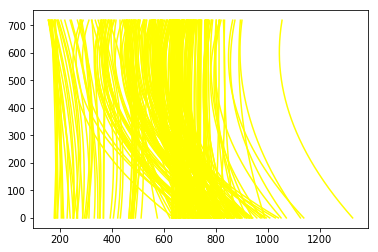

In [22]:
white_output = 'challege_output.mp4.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("challege_output.mp4").subclip(0,5)
#clip1 = VideoFileClip("challege_output.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))